In [1]:
import os
os.chdir("../")

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import datetime
import torch

from models.heston_class import Heston

Feller condition: False


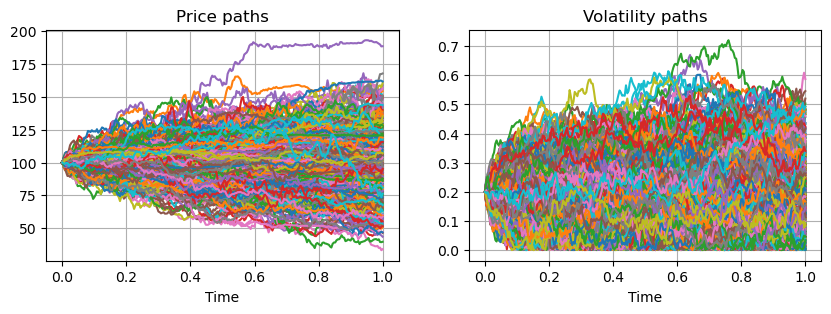

In [2]:
torch.manual_seed(42)

T = torch.tensor(1.0)
dt = torch.tensor(1 / 252)
N = int(T / dt)
S0 = torch.tensor(100.0)
V0 = torch.tensor(0.04)

mu = torch.tensor(0.01)
k = torch.tensor(2.0)
theta = torch.tensor(0.04)
sigma = torch.tensor(0.5)
rho= torch.tensor(-0.3)
heston_model = Heston(mu, k, theta, sigma, rho, V0)

print(f'Feller condition: {2 * k * theta >= sigma**2}')

M = 1000
X = torch.zeros(size=(N, M))
V = torch.zeros(size=(N, M))
for i in range(M):
    logprice, var = heston_model.simulate(torch.log(S0), V0, dt, N)
    X[:, i] = logprice
    V[:, i] = var

fig, axs = plt.subplots(figsize=(10, 3), nrows=1, ncols=2)
S = torch.exp(X)
axs[0].plot(torch.linspace(0, T, N), S.detach())
axs[0].set_title('Price paths')

axs[1].plot(torch.linspace(0, T, N), torch.sqrt(V.detach()))
axs[1].set_title('Volatility paths')

for i in range(2):
    axs[i].set_xlabel('Time')
    axs[i].grid()

/Users/ninocourtecuisse/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


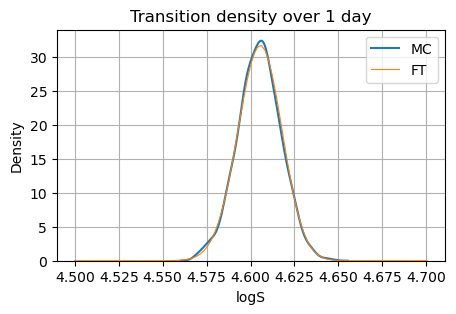

In [3]:
plt.figure(figsize=(5, 3))
sns.kdeplot(X[1], label='MC')

S_next = torch.linspace(S0 - 10, S0 + 10, 100)
transition = heston_model.ft_transition(S0, V0, S_next, dt)
plt.plot(torch.log(S_next), transition.detach(), label='FT', linewidth=0.8)
plt.grid()
plt.xlabel('logS')
plt.legend()
plt.title(f'Transition density over {int(dt * 252)} day')
plt.show()

Feller condition: False


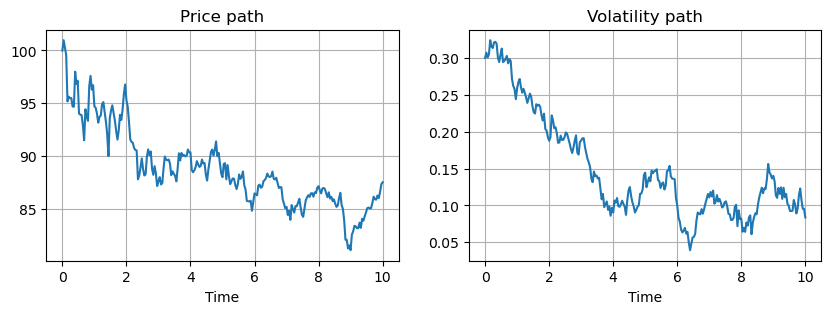

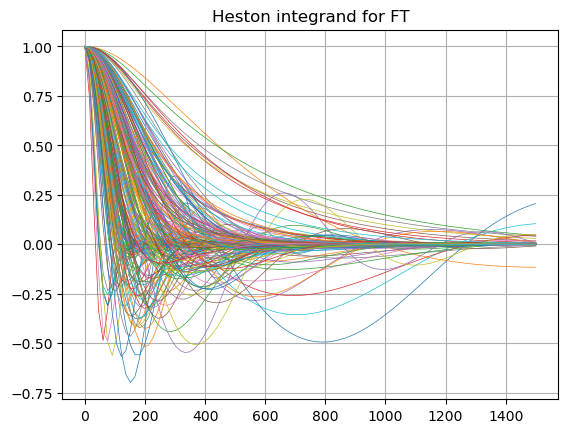

In [4]:
T = torch.tensor(10.0, requires_grad=False)
h = torch.tensor(1/252, requires_grad=False)
n = torch.round(T/h)
S0 = torch.tensor(100.0)
V0 = torch.tensor(0.3**2)

mu_true = torch.tensor(0.01)
k_true = torch.tensor(3.0)
theta_true = torch.tensor(0.1**2)
sigma_true = torch.tensor(0.3)
rho_true = torch.tensor(-0.6)
heston_model = Heston(mu_true, k_true, theta_true, sigma_true, rho_true, V0)

print(f'Feller condition: {2 * k_true * theta_true >= sigma_true**2}')

logprice, var = heston_model.simulate(torch.log(S0), V0, dt, N)
S = torch.exp(logprice)
V = var

fig, axs = plt.subplots(figsize=(10, 3), nrows=1, ncols=2)
axs[0].plot(torch.linspace(0, T, N), S)
axs[0].set_title('Price path')

axs[1].plot(torch.linspace(0, T, N), torch.sqrt(var))
axs[1].set_title('Volatility path')

for i in range(2):
    axs[i].set_xlabel('Time')
    axs[i].grid()
plt.show()

t = len(S) - 1
N = 100
phi = torch.linspace(1e-4, 1500, N)
sigma = torch.tensor(1.5)
model = Heston(mu_true, k_true, theta_true, sigma, rho_true, V0)
S_first = S[:-1]
V_first = V[:-1]
S_next = S[1:]

y1 = model._heston_integrand(S_first, V_first, S_next, phi, dt)
plt.plot(phi, y1.detach(), linewidth=0.5)

plt.title("Heston integrand for FT")
plt.grid()
plt.show()

-> The oscillation are not dampen quickly, especially when the vol of var sigma is large  
-> Need a large integration interval

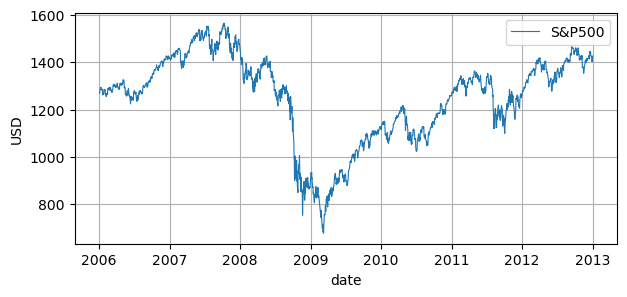

In [5]:
start = datetime.datetime.strptime('2006-01-03', '%Y-%m-%d')
end = datetime.datetime.strptime('2012-12-31', '%Y-%m-%d')

SPOT_PATH = 'data/spx_spot.csv'
spot_data = pd.read_csv(SPOT_PATH, sep=',')
spot_data['date'] = pd.to_datetime(spot_data['date'])
spot_data = spot_data[(spot_data['date'] >= start) & (spot_data['date'] <= end)]
spot_data.set_index('date', inplace=True)

S = spot_data['close'].to_numpy()
dates = spot_data.index.to_numpy()
S = torch.tensor(S, dtype=torch.float32)

plt.figure(figsize=(7, 3))
plt.plot(dates, S, label='S&P500', linewidth=0.8)
plt.ylabel("USD")
plt.xlabel("date")
plt.grid()
plt.legend()
plt.show()

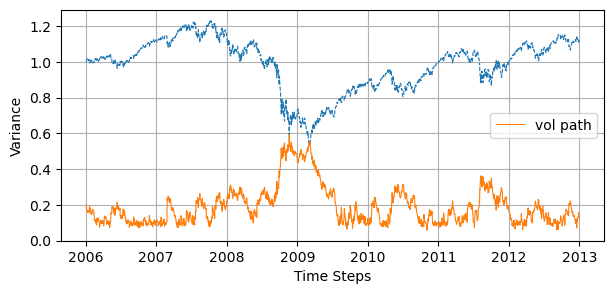

In [6]:
dt = torch.tensor(1/252, requires_grad=False)
# Example of a heston volatility path, conditional on spot path
mu = torch.tensor(-0.1)
k = torch.tensor(1.0)
theta = torch.tensor(0.03)
sigma = torch.tensor(0.8)
rho = torch.tensor(-0.7)
v0 = torch.tensor(0.04)

plt.figure(figsize=(7, 3))
plt.plot(dates, S / S[0], linewidth=0.8, linestyle='--')
model = Heston(mu, k, theta, sigma, rho, v0)
init_var = model.variance_path_mm(S, dt)
plt.plot(dates, torch.sqrt(init_var.detach()), linewidth=0.8, label='vol path')
plt.ylabel("Variance")
plt.xlabel("Time Steps")
plt.legend()
plt.grid()

Feller condition: False
Init params: mu: 0.009999999776482582, k: 1.0, theta: 0.03999999910593033, sigma: 0.5, rho: -0.30000001192092896, v0: 0.03999999910593033
Calib params: mu: 0.001826394465751946, k: 1.924619436264038, theta: 0.05412327125668526, sigma: 0.48982855677604675, rho: -0.6066759824752808, v0: 0.03999999910593033


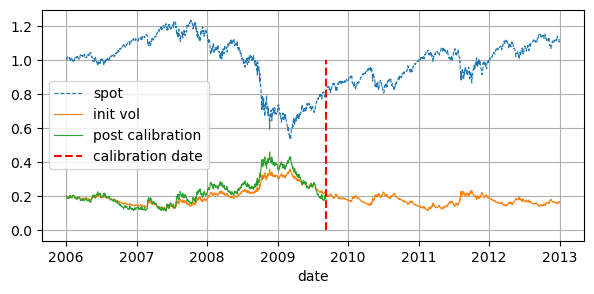

In [7]:
dt = torch.tensor(1/252, requires_grad=False)
T = len(S)
torch.manual_seed(1)

# Initial parameters
mu = torch.tensor(0.01)
k = torch.tensor(1.0)
theta = torch.tensor(0.04)
sigma = torch.tensor(0.5)
rho = torch.tensor(-0.3)
v0 = torch.tensor(0.04)

print(f'Feller condition: {2 * k * theta >= sigma**2}')

model = Heston(mu, k, theta, sigma, rho, v0)
mu, k, theta, sigma, rho, v0 = model.inv_reparam()
print(f"Init params: mu: {mu.item()}, k: {k.item()}, theta: {theta.item()}, sigma: {sigma.item()}, rho: {rho.item()}, v0: {v0.item()}")

# Initial var path
init_var = model.variance_path_mm(S, dt)
t = len(S) // 2
t = 927

optimizer = torch.optim.Adam([
    {'params': model.mu, 'lr': 0.1},
    {'params': model.l_k, 'lr': 0.1},
    {'params': model.l_theta, 'lr': 0.1},
    {'params': model.l_sigma, 'lr': 0.1},
    {'params': model.at_rho, 'lr': 0.1},
])
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
for epoch in range(50):
    #print(epoch)
    optimizer.zero_grad()
    loss = -model(S, t=t, window=200)
    loss.backward()
    optimizer.step()

    #mu, k, theta, sigma, rho, v0 = model.inv_reparam()
    #print(f"epoch: {epoch}, mu: {mu.item()}, k: {k.item()}, theta: {theta.item()}, sigma: {sigma.item()}, rho: {rho.item()}, v0: {v0.item()}")
    #print(f"mu: {model.mu.grad.item()}, k: {model.l_k.grad.item()}, theta: {model.l_theta.grad.item()}, sigma: {model.l_sigma.grad.item()}, rho: {model.at_rho.grad.item()}")

mu, k, theta, sigma, rho, v0 = model.inv_reparam()
print(f"Calib params: mu: {mu.item()}, k: {k.item()}, theta: {theta.item()}, sigma: {sigma.item()}, rho: {rho.item()}, v0: {v0.item()}")

# var path post calibration
post_var = model.variance_path_mm(S[:t], dt)

plt.figure(figsize=(7, 3))
plt.plot(dates, S / S[0], label='spot', linewidth=0.8, linestyle='--')
plt.plot(dates, torch.sqrt(init_var.detach()), label='init vol', linewidth=0.8)
plt.plot(dates[:t], torch.sqrt(post_var.detach()), label='post calibration', linewidth=0.8)
plt.vlines(dates[t], 0, 1, color='red', linestyle='--', label='calibration date')
plt.xlabel("date")
plt.grid()
plt.legend()
plt.show()

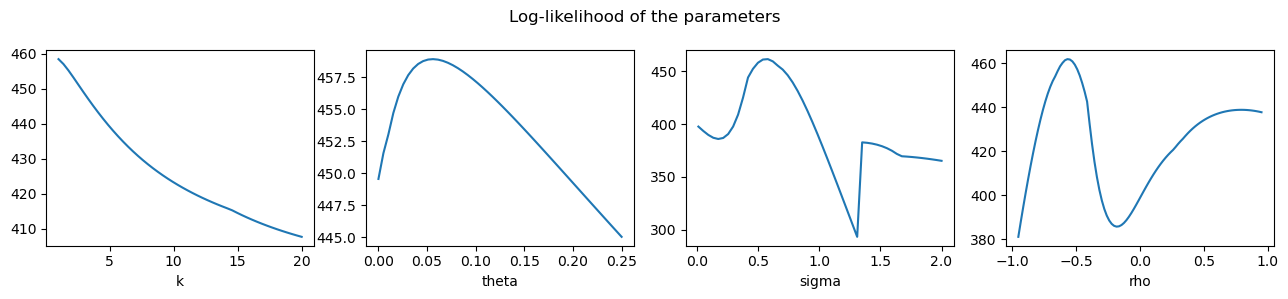

In [8]:
# Plot the likelihood slices

mu_true = torch.tensor(0.01)
k_true = torch.tensor(1.0)
theta_true = torch.tensor(0.04)
sigma_true = torch.tensor(0.5)
rho_true = torch.tensor(-0.5)
v0 = torch.tensor(0.04)

n_params = 4
fig, axs = plt.subplots(figsize=(13, 3), nrows=1, ncols=n_params)
window=200
t = len(S) // 2 - 200
t = 927

ks = torch.linspace(1.0, 20.0, 50)
likelihood = torch.zeros_like(ks)
for i, k in enumerate(ks):
    model = Heston(mu_true, k, theta_true, sigma_true, rho_true, v0)
    likelihood[i] = model.forward(S, t=t, window=window)
axs[0].plot(ks, likelihood.detach(), label='log-likelihood')
axs[0].set_xlabel('k')

thetas = torch.linspace(0.001**2, 0.5**2, 50)
likelihood = torch.zeros_like(thetas)
for i, theta in enumerate(thetas):
    model = Heston(mu_true, k_true, theta, sigma_true, rho_true, v0)
    likelihood[i] = model.forward(S, t=t, window=window)
axs[1].plot(thetas, likelihood.detach(), label='log-likelihood')
axs[1].set_xlabel('theta')

sigmas = torch.linspace(0.01, 2.0, 50)
likelihood = torch.zeros_like(sigmas)
for i, sigma in enumerate(sigmas):
    model = Heston(mu_true, k_true, theta_true, sigma, rho_true, v0)
    likelihood[i] = model.forward(S, t=t, window=window)
axs[2].plot(sigmas, likelihood.detach(), label='log-likelihood')
axs[2].set_xlabel('sigma')

rhos = torch.linspace(-0.95, 0.95, 100)
likelihood = torch.zeros_like(rhos)
for i, rho in enumerate(rhos):
    model = Heston(mu_true, k_true, theta_true, sigma_true, rho, v0)
    likelihood[i] = model.forward(S, t=t, window=window)
axs[3].plot(rhos, likelihood.detach(), label='log-likelihood')
axs[3].set_xlabel('rho')

fig.suptitle('Log-likelihood of the parameters')
fig.tight_layout()
plt.show()